In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import sklearn.linear_model as lm
import sklearn.ensemble as ens
import sklearn.neural_network as nn

In [3]:
def natural_sort(l):
    def convert(text): return int(text) if text.isdigit() else text.lower()

    def alphanum_key(key): return [convert(c)
                                   for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [4]:
dataset_path = "mtist_datasets"
es_score_path = "mtist_datasets/output_geom/inference_result_infer_from_did_geom_mean"
n_dset = len([i for i in os.listdir(es_score_path) if i.split("_")[0]=="inferred"])

dataset_files = [i for i in os.listdir(dataset_path) if i.split("_")[0]=="dataset" and int(re.findall("_([0-9]+).csv", i)[0]) < n_dset]
dataset_files = natural_sort(dataset_files)

In [5]:
es_scores = pd.read_csv(f"{es_score_path}/es_scores.csv", index_col=0)
new_es_scores = pd.read_csv(f"{es_score_path}/new_es_scores.csv", index_col=0)

In [6]:
def samp_scheme_conv(scheme):
    if scheme == "even":
        return 0
    elif scheme == "seq":
        return 1
    else:
        return 2

In [7]:
dset_param_cols = ["n_species", "n_timeseries", "n_timepoints", "noise", "seq_depth", "sampling_scheme", "dt"]
dset_param_vals = []

for dset in dataset_files:
    df = pd.read_csv(f"{dataset_path}/{dset}", index_col=0)
    df["sampling_scheme"] = samp_scheme_conv(df["sampling_scheme"][0])
    df["seq_depth"] = len(df["seq_depth"][0])-3
    # df["dt"] = pd.DataFrame(np.diff(df["time"])[np.diff(df["time"])>=0]).mode().values[0,0]
    df["dt"] = np.round(np.median(np.diff(df["time"])[np.diff(df["time"])>=0]), 6)
    dset_param_vals.append(np.unique(df[dset_param_cols], axis=0))

In [8]:
df = pd.DataFrame(np.concatenate(dset_param_vals), columns=dset_param_cols)
df[["es_score_raw", "es_score_floored"]] = es_scores
df[["new_es_score_raw", "new_es_score_floored"]] = new_es_scores

df

,n_species,n_timeseries,n_timepoints,noise,seq_depth,sampling_scheme,dt,es_score_raw,es_score_floored,new_es_score_raw,new_es_score_floored
0,100.0,5.0,5.0,0.01,1.0,0.0,7.575758,0.514210,0.501445,0.110600,0.761900
1,100.0,5.0,10.0,0.01,1.0,0.0,3.333333,0.512042,0.516137,0.106300,0.654600
2,100.0,5.0,15.0,0.01,1.0,0.0,2.121212,0.500963,0.501927,0.104000,0.345700
3,100.0,5.0,5.0,0.01,1.0,2.0,3.939394,0.508430,0.500000,0.101300,0.752700
4,100.0,5.0,10.0,0.01,1.0,2.0,2.424242,0.511561,0.510597,0.106200,0.511800
...,...,...,...,...,...,...,...,...,...,...,...
1129,3.0,50.0,10.0,0.10,0.0,2.0,2.424242,0.888889,0.833333,0.888889,0.666667
1130,3.0,50.0,15.0,0.10,0.0,2.0,1.212121,1.000000,1.000000,1.000000,1.000000
1131,3.0,50.0,5.0,0.10,0.0,1.0,1.212121,1.000000,1.000000,1.000000,1.000000
1132,3.0,50.0,10.0,0.10,0.0,1.0,1.212121,1.000000,1.000000,1.000000,1.000000


In [10]:
n_sp = 10.
df_n_sp = df[df.n_species==n_sp]
# df_n_sp = df_n_sp[df_n_sp["seq_depth"]==1.]
feat = df_n_sp.iloc[:,1:7].values
label = df_n_sp["es_score_raw"].values
new_label = df_n_sp["new_es_score_raw"].values

lr = lm.LinearRegression()
lr.fit(feat, label)
lr.score(feat, label)

0.46799055813852086

(array([[0.52375608, 0.59857838, 0.67340067, 1.87055743, 2.02020202,
         4.33969323, 4.19004863, 2.6187804 , 0.59857838, 0.74822297],
        [0.29928919, 0.59857838, 1.04751216, 2.76842499, 2.4691358 ,
         3.89075945, 3.81593715, 2.02020202, 0.97268986, 0.29928919]]),
 array([0.33 , 0.385, 0.44 , 0.495, 0.55 , 0.605, 0.66 , 0.715, 0.77 ,
        0.825, 0.88 ]),
 <a list of 2 list[Polygon] objects>)

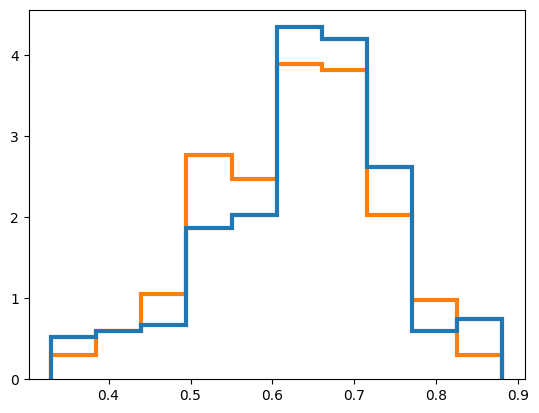

In [11]:
plt.hist([df_n_sp[df_n_sp["seq_depth"]==i]["new_es_score_raw"] for i in df_n_sp["seq_depth"].unique()], histtype="step", lw=3, density=True)

In [12]:
df["noise"].unique()

array([0.01, 0.05, 0.1 ])

In [13]:
df["n_timepoints"].unique()

array([ 5., 10., 15.])

In [14]:
df["n_timeseries"].unique()

array([ 5., 10., 50.])

In [15]:
df["sampling_scheme"].unique()

array([0., 2., 1.])

In [16]:
np.sort(df["dt"].unique())

array([1.212121, 2.121212, 2.424242, 3.333333, 3.939394, 7.575758])

In [17]:
lr.intercept_, lr.coef_

(0.761703787427637,
 array([ 0.00218416,  0.00441322,  0.0442839 ,  0.01676548, -0.00010381,
        -0.03495636]))

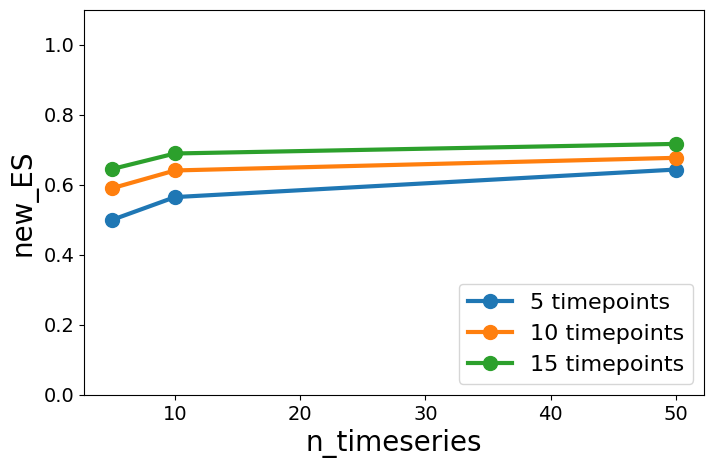

In [19]:
plt.figure(figsize=(8,5))
for j, n_tp in enumerate(df["n_timepoints"].unique()):
    plt.plot([i for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,i]).all(1).values]["new_es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=10, lw=3, label=f"{n_tp:.0f} timepoints")

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("new_ES", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

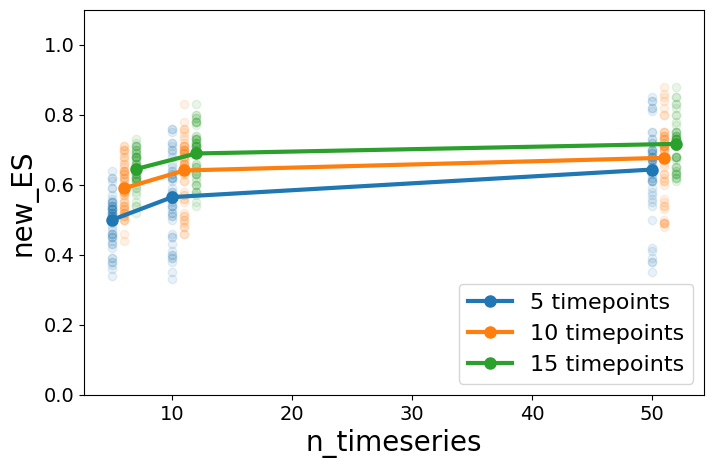

In [20]:
plt.figure(figsize=(8,5))

for i, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
    for j, n_tp in enumerate(df_n_sp["n_timepoints"].unique()):
        plt.scatter((n_ts+j)*np.ones_like(df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["new_es_score_raw"].values), df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["new_es_score_raw"].values, c=f"C{j}", alpha=0.1)

for j, n_tp in enumerate(df["n_timepoints"].unique()):
    plt.plot([i+j for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,i]).all(1).values]["new_es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=8, lw=3, label=f"{n_tp:.0f} timepoints")

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("new_ES", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [21]:
df["sampling_scheme"].unique()

array([0., 2., 1.])

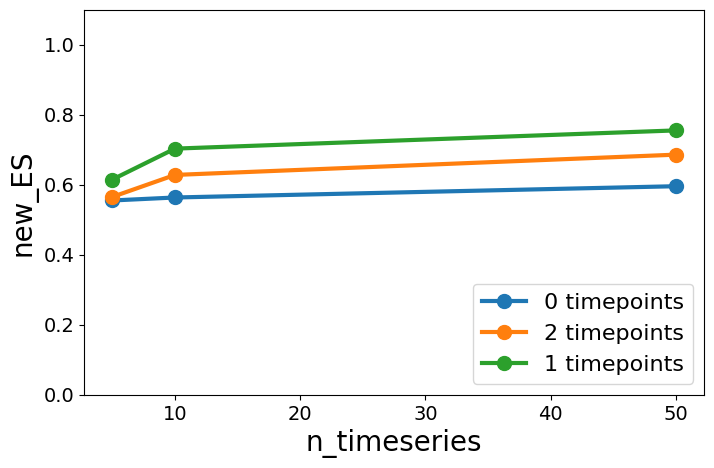

In [23]:
plt.figure(figsize=(8,5))

for i, n_ts in enumerate(df["n_timeseries"].unique()):
    for j, n_tp in enumerate(df["sampling_scheme"].unique()):
        plt.scatter(n_ts, df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["new_es_score_raw"].values.mean(), c=f"C{j}")

for j, n_tp in enumerate(df["sampling_scheme"].unique()):
    plt.plot([i for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,i]).all(1).values]["new_es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=10, lw=3, label=f"{n_tp:.0f} timepoints")

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("new_ES", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [24]:
df["sampling_scheme"].unique()

array([0., 2., 1.])

In [25]:
samp_schem = ["even", "random", "seq"]

In [61]:
df["n_timepoints"].unique()

array([ 5., 10., 15.])

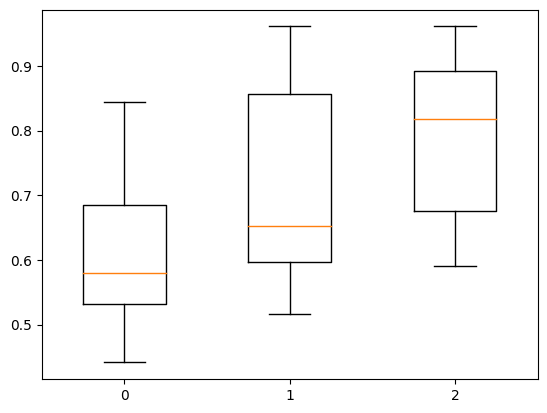

In [68]:
for i, n_ts in enumerate(df["n_timepoints"].unique()):
    plt.boxplot(df_n_sp[(df_n_sp[["sampling_scheme", "n_timepoints"]]==[0,n_ts]).all(1).values]["es_score_raw"].values, positions=[i], widths=0.5)

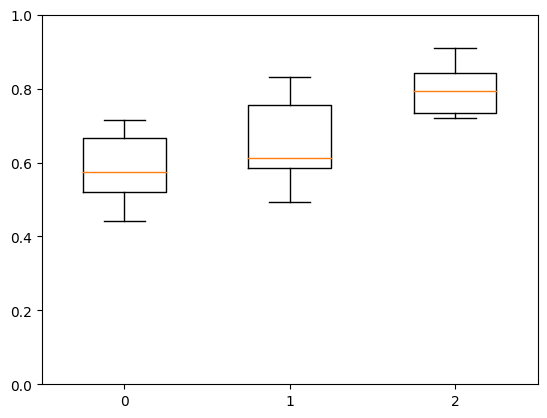

In [89]:
for i, n_ts in enumerate(df["n_timeseries"].unique()):
    plt.boxplot(df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries", "n_timepoints"]]==[2,n_ts,5]).all(1).values]["es_score_raw"].values, positions=[i], widths=0.5)
plt.ylim(0, 1)
plt.show()

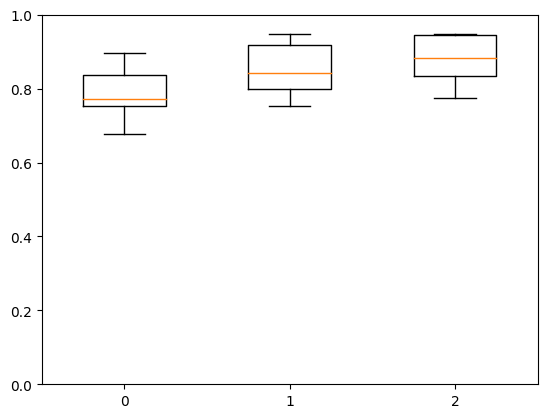

In [90]:
for i, n_ts in enumerate(df["n_timeseries"].unique()):
    plt.boxplot(df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries", "n_timepoints"]]==[2,n_ts,15]).all(1).values]["es_score_raw"].values, positions=[i], widths=0.5)
plt.ylim(0, 1)
plt.show()

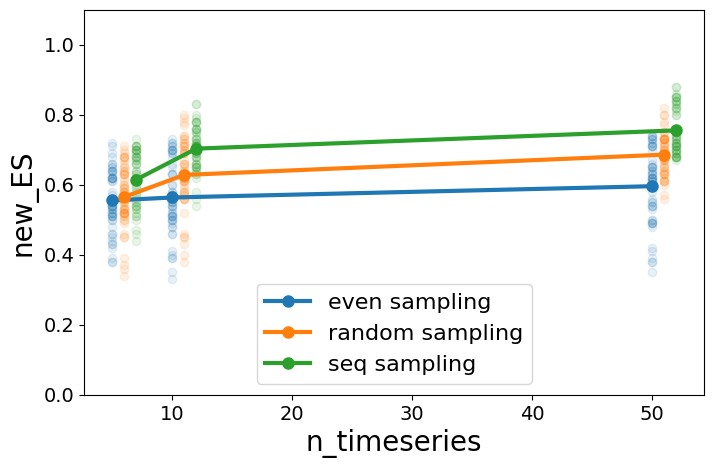

In [26]:
plt.figure(figsize=(8,5))

for i, n_ts in enumerate(df["n_timeseries"].unique()):
    for j, n_tp in enumerate(df["sampling_scheme"].unique()):
        plt.scatter((n_ts+j)*np.ones_like(df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["new_es_score_raw"].values), df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["new_es_score_raw"].values, c=f"C{j}", alpha=0.1)
        
for j, n_tp in enumerate(df["sampling_scheme"].unique()):
    plt.plot([i+j for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,i]).all(1).values]["new_es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=8, lw=3, label=f"{samp_schem[j]} sampling")

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("new_ES", fontsize=20)
plt.legend(loc="lower center", fontsize=16)
plt.show()

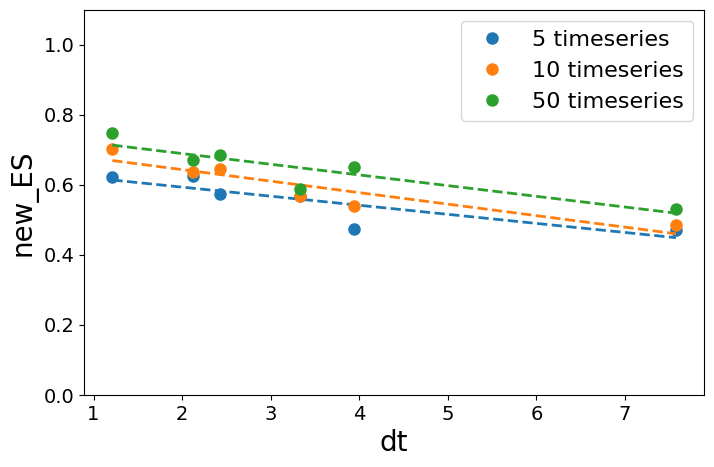

In [27]:
new_es_vs_dt = np.zeros((len(df_n_sp["n_timeseries"].unique()), len(df_n_sp["dt"].unique())))

for i, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
    for j, n_tp in enumerate(df_n_sp[df_n_sp["n_timeseries"]==n_ts]["dt"].unique()):
        new_es_vs_dt[i,j] = df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["new_es_score_raw"].values.mean()

plt.figure(figsize=(8,5))
        
for i in range(new_es_vs_dt.shape[0]):
    new_es_vs_dt[i] = new_es_vs_dt[i][np.argsort(df_n_sp["dt"].unique())]
    lr = lm.LinearRegression()
    lr.fit(df_n_sp["dt"].unique()[np.argsort(df_n_sp["dt"].unique())].reshape((-1,1)), new_es_vs_dt[i])
    plt.plot(df_n_sp["dt"].unique()[np.argsort(df_n_sp["dt"].unique())], new_es_vs_dt[i], "o", c=f"C{i}", ms=8, label=f"{df_n_sp['n_timeseries'].unique()[i]:.0f} timeseries")
    plt.plot(df_n_sp["dt"].unique()[np.argsort(df_n_sp["dt"].unique())], lr.predict(df_n_sp["dt"].unique()[np.argsort(df_n_sp["dt"].unique())].reshape((-1,1))), c=f"C{i}", ls="--", lw=2)
    
plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("dt", fontsize=20)
plt.ylabel("new_ES", fontsize=20)
plt.legend(loc="upper right", fontsize=16)
plt.show()

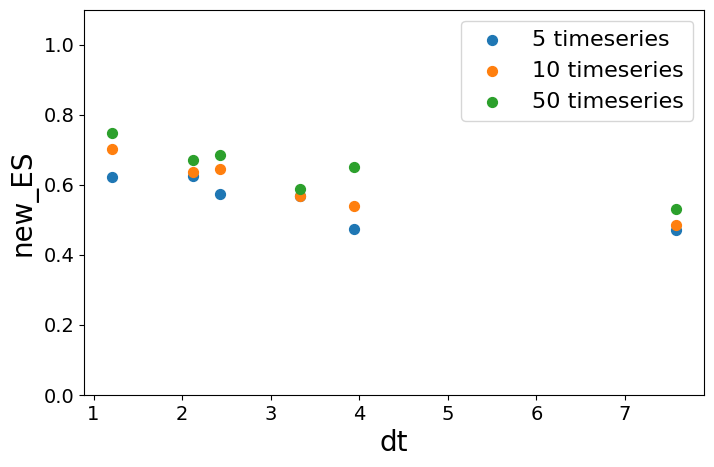

In [28]:
plt.figure(figsize=(8,5))

for i, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
    for j, n_tp in enumerate(df_n_sp[df_n_sp["n_timeseries"]==n_ts]["dt"].unique()):
        if j == 0:
            plt.scatter(n_tp, df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["new_es_score_raw"].values.mean(), c=f"C{i}", s=50, label=f"{n_ts:.0f} timeseries")
        else:
            plt.scatter(n_tp, df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["new_es_score_raw"].values.mean(), c=f"C{i}", s=50)

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("dt", fontsize=20)
plt.ylabel("new_ES", fontsize=20)
plt.legend(loc="upper right", fontsize=16)
plt.show()

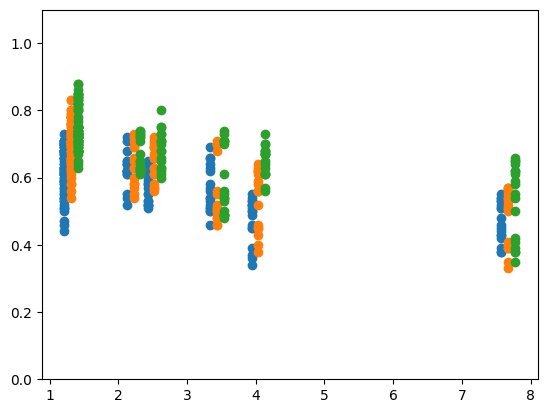

In [42]:
for i, n_ts in enumerate(df["n_timeseries"].unique()):
    for j, n_tp in enumerate(df[df["n_timeseries"]==n_ts]["dt"].unique()):
        plt.scatter((n_tp+i*0.1)*np.ones_like(df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["new_es_score_raw"].values), df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["new_es_score_raw"].values, c=f"C{i}")
        
plt.ylim(0, 1.1)
# plt.xscale("log")
plt.show()

In [30]:
lr = lm.LinearRegression()
lr.fit(feat, new_label)
lr.score(feat, new_label)

0.5114259777321543

In [31]:
lr.coef_

array([ 0.00183291,  0.00367445,  0.05317749,  0.01485597,  0.00158974,
       -0.02846733])

In [32]:
rfr = ens.RandomForestRegressor(100)
rfr.fit(feat, label)
print(rfr.score(feat, label))

rfr = ens.RandomForestRegressor(100)
rfr.fit(feat, new_label)
print(rfr.score(feat, new_label))

0.5901759761026747
0.6557887720064313


In [33]:
gfr = ens.GradientBoostingRegressor()
gfr.fit(feat, label)
print(gfr.score(feat, label))

gfr = ens.GradientBoostingRegressor()
gfr.fit(feat, new_label)
print(gfr.score(feat, new_label))

0.581823835825156
0.6454968883060048


In [34]:
(np.loadtxt("/home/valeriano/Documents/BEPE/mtist/mtist1.0/ground_truths/interaction_coefficients/100_sp_aij.csv", delimiter=",")==0).mean()

0.7924